# Neutron Diffusion in Python 

This notebook is an entirely self-contained solution to a basic [neutron diffision](http://mragheb.com/NPRE%20402%20ME%20405%20Nuclear%20Power%20Engineering/One%20Group%20Reactor%20Theory.pdf) equation for a reactor *rx* made up of a single fuel rod. The one-group diffusion equation that we will be stepping through time and space is, 

$\frac{1}{v}\frac{\partial \phi}{\partial t} = D \nabla^2 \phi + (k - 1) \Sigma_a \phi + S$

where 

* $\phi$ is the neutron flux [$n/\text{cm}^2/\text{s}$],
* $D$ is the diffusion coefficient [$\text{cm}$],
* $k$ is the multiplication factor of the material [unitless],
* $S$ is a static source term [$n/\text{cm}^2/\text{s}$], and
* $v$ is the neutron velocity, which for [thermal neutrons](http://en.wikipedia.org/wiki/Neutron_temperature) is 2.2e5 [$\text{cm/s}$]

## Make a Mesh

PyNE Meshes can be used to compute all of the nuclear data needs here and for a semi-structured MOAB Hex8 meshes. The simulation, analysis, and visulaization here takes place entirely within memory.

In [1]:
# Import necessary modules
from itertools import product
from pyne.mesh import Mesh, NativeMeshTag
from pyne.xs.cache import XSCache
from pyne.xs.data_source import SimpleDataSource, NullDataSource
from pyne.xs.channels import sigma_a, sigma_s
from pyne.material import from_atom_frac
import numpy as np
from yt.frontends.moab.api import PyneMoabHex8Dataset
from yt import SlicePlot
from pymoab import types
from matplotlib import animation
from matplotlib.backends.backend_agg import FigureCanvasAgg
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter
import logging

# Disable all logging outputs
logging.disable(logging.CRITICAL)

Initialize XSCache with group structure and data sources

In [2]:
xsc = XSCache(group_struct=[0.026e-6, 0.024e-6],
              data_sources=[SimpleDataSource, NullDataSource])

## The Laplacian

The functions in the following cells solve for the laplacian ($\nabla^2$) for any index in in the mesh using a [3 point stencil](http://en.wikipedia.org/wiki/Five-point_stencil) along each axis. This implements reflecting boundary conditions along the edges of the domain.

### Function: lpoint(idx, n, coords, shape, m)

 This function computes the left neighboring point of a given index `idx` along the `n`-th axis in a structured mesh `m`. The `coords` parameter represents the coordinates of the current entity, and the `shape` parameter is the shape of the structured mesh. The function implements reflecting boundary conditions along the edges of the domain by handling the cases when the index is at the boundary.

In [3]:
def lpoint(idx, n, coords, shape, m):
    lidx = list(idx)
    lidx[n] += 1 if idx[n] == 0 else -1
    left = m.structured_get_hex(*lidx)
    l = m.mesh.get_coords(left)[n]
    if idx[n] == 0:
        l = 2 * coords[n] - l
    return left, l

### Function: rpoint(idx, n, coords, shape, m)

This function computes the right neighboring point of a given index `idx` along the `n`-th axis in a structured mesh `m`. The `coords` parameter represents the coordinates of the current entity, and the `shape` parameter is the shape of the structured mesh. The function implements reflecting boundary conditions along the edges of the domain by handling the cases when the index is at the boundary.

In [4]:
def rpoint(idx, n, coords, shape, m):
    ridx = list(idx)
    ridx[n] += -1 if idx[n] == shape[n] - 2 else 1
    right = m.structured_get_hex(*ridx)
    r = m.mesh.get_coords(right)[n]
    if idx[n] == shape[n] - 2:
        r = 2 * coords[n] - r
    return right, r

### Function: laplace(tag, idx, m, shape)

This function computes the Laplacian of a tag (a scalar field associated with each mesh entity) at a given index `idx` in a structured mesh `m`. The `tag` parameter is the tag associated with the scalar field. The `shape` parameter is the shape of the structured mesh. The function calculates the Laplacian using a 3-point stencil along each axis. It uses the neighboring points to retrieve tag values to approximate the derivatives along each axis and then computes the Laplacian using the finite difference method.



In [5]:
def laplace(tag, idx, m, shape):
    ent = m.structured_get_hex(*idx)
    coords = m.mesh.get_coords(ent)
    lptag = 0.0
    for n in range(3):
        left, l = lpoint(idx, n, coords, shape, m)
        right, r = rpoint(idx, n, coords, shape, m)
        c = coords[n]

        # Retrieve the tag values for the entities
        tag_data_ent = m.mesh.tag_get_data(tag, ent)[0]
        tag_data_left = m.mesh.tag_get_data(tag, left)[0]
        tag_data_right = m.mesh.tag_get_data(tag, right)[0]
        lptag += (((tag_data_right - tag_data_ent) / (r - c)) -
                  ((tag_data_ent - tag_data_left) / (c - l))) / ((r - l) / 2)
    return lptag

## Solve in space

The ``timestep()`` function sweeps through the entire mesh and computes the new flux everywhere.  This operation takes place entirely on the mesh object.

### Function: timestep(m, dt)

This function calculates the time step update for the variable `phi` on a given mesh `m` using a simple time integration method. The time step update is computed for each entity (hexahedral cell) in the mesh.

#### Parameters:

- `m`: The mesh object (of type `pyne.mesh.Mesh`) on which the time step update is performed.
- `dt`: The time step size for the integration.

#### Tags:

The function uses several tags (scalar fields associated with each entity) on the mesh to retrieve and store data:

- `D`: Tag representing the diffusion coefficient (`D_val`) associated with each entity (cell) in the mesh.
- `k`: Tag representing the multiplication factor (`k_val`) associated with each entity in the mesh.
- `S`: Tag representing the source term (`S_val`) associated with each entity in the mesh.
- `Sigma_a`: Tag representing the absorption cross-section (`Sigma_a_val`) associated with each entity in the mesh.
- `flux (phi)`: Tag representing the current value of the scalar field (`phi_val`) for each entity in the mesh.
- `phi_next`: Tag representing the updated value of the scalar field (`phi_next_val`) after the time step for each entity in the mesh.

#### Algorithm:

1. The function retrieves the number of divisions along the x, y, and z axes (`nx`, `ny`, and `nz`) from the mesh object `m`.
2. The shape of the mesh (`shape`) is computed as a tuple containing `(nx, ny, nz)`.
3. Tags for various parameters (`D`, `k`, `S`, `Sigma_a`, `flux`, and `phi_next`) are retrieved from the mesh object using `m.mesh.tag_get_handle`.
4. The function iterates over all the entities (hexahedral cells) in the mesh using the `product` function, which generates the Cartesian product of index ranges for each axis.
5. For each entity, the function retrieves the values of `phi`, `D`, `k`, `Sigma_a`, and `S` associated with that entity.
6. Using the retrieved values, the function computes the new value of the scalar field `phi_next_val` at the next time step for that entity. The calculation involves solving a simple diffusion equation with a source term and a multiplication factor `k`.
7. The calculated `phi_next_val` is stored in the `phi_next` tag for the current entity.
8. After the iteration over all entities is complete, the function updates the `phi` tag with the newly calculated `phi_next` values using `m.mesh.tag_set_data`.

#### Time Integration:

The time integration method used in this function is explicit, where the value of the scalar field at the next time step (`phi_next`) is directly computed from the values at the current time step (`phi`) without the need for solving a system of equations. The time integration method is a first-order approximation based on a finite difference formulation.

#### Notes:

- The calculated `phi_next_val` is clamped to a minimum value of 0 to ensure non-negativity.
- The `dt` parameter is used to advance the time step and control the rate of change in the scalar field.

In [6]:
def timestep(m, dt):
    nx = len(m.structured_get_divisions("x"))
    ny = len(m.structured_get_divisions("y"))
    nz = len(m.structured_get_divisions("z"))
    shape = (nx, ny, nz)
    D = m.mesh.tag_get_handle("D")
    k = m.mesh.tag_get_handle("k")
    S = m.mesh.tag_get_handle("S")
    Sigma_a = m.mesh.tag_get_handle("Sigma_a")
    phi = m.mesh.tag_get_handle("flux")
    phi_next = m.mesh.tag_get_handle("phi_next")
    for idx in product(*[range(xyz - 1) for xyz in shape]):
        ent = m.structured_get_hex(*idx)
        # Get the value of phi for the entity
        phi_val = m.mesh.tag_get_data(phi, ent)[0]
        # Get the value of D for the entity
        D_val = m.mesh.tag_get_data(D, ent)[0]
        # Get the value of k for the entity
        k_val = m.mesh.tag_get_data(k, ent)[0]
        # Get the value of Sigma_a for the entity
        Sigma_a_val = m.mesh.tag_get_data(Sigma_a, ent)[0]
        # Get the value of S for the entity
        S_val = m.mesh.tag_get_data(S, ent)[0]

        # Perform calculations using the retrieved values
        phi_next_val = (max(
            D_val * laplace(phi, idx, m, shape) +
            (k_val - 1.0) * Sigma_a_val * phi_val, 0.0
        ) + S_val) * dt * 2.2e5 + phi_val

        # Store the calculated phi_next_val back to the phi_next tag for the entity
        m.mesh.tag_set_data(phi_next, ent, phi_next_val)

    ents = m.mesh.get_entities_by_type(
        m.mesh.get_root_set(), types.MBENTITYSET)
    # Retrieve all phi_next values for entities
    phi_val_next = m.mesh.tag_get_data(phi_next, ents)
    # Update the phi tag with the new phi_next values
    m.mesh.tag_set_data(phi, ents, phi_val_next)

## Reactor

This setups up a simple light water reactor fuel pin in a water cell. Note that our cells are allowed to have varing aspect ratios.  This allows us to be coarsely refined inside of the pin, finely refined around the edge of the pin, and then have a different coarse refinement out in the coolant.

### Function: isinrod(ent, rx, radius=0.4)

This function determines whether a given entity (hexahedral cell) is inside a control rod based on its coordinates. It takes the following parameters:

- `ent`: The entity (cell) for which to check if it is inside the control rod.
- `rx`: The mesh object (of type `pyne.mesh.Mesh`) representing the reactor geometry.
- `radius`: The radius of the control rod. The default value is 0.4.

The function calculates the square of the distance from the center of the mesh cell (`ent`) to the origin (0, 0) in the x-y plane. If this distance squared is less than or equal to the square of the control rod radius, the function returns `True`, indicating that the entity is inside the control rod. Otherwise, it returns `False`.

In [7]:
def isinrod(ent, rx, radius=0.4):
    coord = rx.mesh.get_coords(ent)
    # Returns whether an entity is in a control rod
    return (coord[0] ** 2 + coord[1] ** 2) <= radius ** 2


### Function: create_reactor(multfact=1.0, radius=0.4)

This function sets up a simple light water reactor fuel pin in a water cell. It creates a mesh representing the reactor geometry and assigns initial conditions for various parameters associated with each entity (cell) in the mesh. The function takes the following parameters:

- `multfact`: A multiplier factor for the multiplication factor (`k`) of the reactor. The default value is 1.0.
- `radius`: The radius of the control rod. The default value is 0.4.

#### Materials:

The function defines two materials:
- `fuel`: Represents the fuel material with a composition containing uranium-235, uranium-238, and oxygen-16, and a density of 10.7 g/cm^3.
- `cool`: Represents the coolant material with a composition containing hydrogen-1 and oxygen-16, and a density of 1.0 g/cm^3.

#### Mesh and Tags:

The function creates a mesh (`rx`) with structured coordinates in three dimensions (x, y, z) based on specified `xpoints`, `ypoints`, and `zpoints`. It also creates several tags (scalar fields associated with each entity) on the mesh to store and retrieve data:
- `D`: Represents the diffusion coefficient for each entity in the mesh.
- `k`: Represents the multiplication factor for each entity in the mesh.
- `S`: Represents the source term for each entity in the mesh.
- `Sigma_a`: Represents the absorption cross-section for each entity in the mesh.
- `flux (phi)`: Represents the initial value of the scalar field (flux) for each entity in the mesh.
- `phi_next`: Represents the updated value of the scalar field (flux) after the time step for each entity in the mesh.

#### Algorithm:

The function iterates over all entities in the mesh (`rx`). For each entity, it determines whether it is inside the control rod using the `isinrod` function. Based on whether the entity is inside the control rod or not, it assigns the corresponding values of `D`, `Sigma_a`, `phi`, and `k` for the entity based on the materials and the specified `multfact` and `radius`.

After setting up the initial conditions for all entities, the `D`, `Sigma_a`, `flux`, `k`, `S`, and `phi_next` tags are updated with the computed values for each entity in the mesh.

#### Notes:

- The diffusion coefficient `D` is calculated using the material properties and cross-section data (retrieved using the `xsc` cross-section cache).
- The flux `phi` for entities inside the control rod is set to a constant value (4e14) while the flux for entities outside the control rod varies based on their distance from the center (decreasing proportionally with the square of the distance).
- The multiplication factor `k` for entities inside the control rod is set to the specified `multfact`, while for entities outside the control rod, it is set to 0.0.
- The `S` and `phi_next` tags are initially set to 0.0.


In [8]:
def create_reactor(multfact=1.0, radius=0.4):
    fuel = from_atom_frac(
        {'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, density=10.7)
    cool = from_atom_frac({'H1': 2.0, 'O16': 1.0}, density=1.0)
    xpoints = [0.0, 0.075, 0.15, 0.225] + \
        list(np.arange(0.3, 0.7, 0.025)) + list(np.arange(0.7, 1.201, 0.05))
    ypoints = xpoints
    zpoints = np.linspace(0.0, 1.0, 8)
    # Make Mesh
    rx = Mesh(structured_coords=[xpoints, ypoints, zpoints], structured=True)
    # Add Tags
    rx.D = NativeMeshTag(size=1, dtype=float)
    rx.k = NativeMeshTag(size=1, dtype=float)
    rx.S = NativeMeshTag(size=1, dtype=float)
    rx.Sigma_a = NativeMeshTag(size=1, dtype=float)
    rx.flux = NativeMeshTag(size=1, dtype=float)
    rx.phi_next = NativeMeshTag(size=1, dtype=float)
    # Assign initial conditions
    Ds = []
    Sigma_as = []
    phis = []
    ks = []
    for i, mat, ent in rx:
        if isinrod(ent, rx, radius=radius):
            Ds.append(1.0 / (3.0 * fuel.density * 1e-24 *
                      sigma_s(fuel, xs_cache=xsc)))
            Sigma_as.append(fuel.density * 1e-24 * sigma_a(fuel, xs_cache=xsc))
            phis.append(4e14)
            ks.append(multfact)
        else:
            Ds.append(1.0 / (3.0 * cool.density * 1e-24 *
                      sigma_s(cool, xs_cache=xsc)))
            Sigma_as.append(cool.density * 1e-24 * sigma_a(cool, xs_cache=xsc))
            r2 = (rx.mesh.get_coords(ent)[:2]**2).sum()
            phis.append(4e14 * radius**2 / r2 if r2 < 0.7**2 else 0.0)
            ks.append(0.0)
    rx.D[:] = np.array(Ds)[:, 0]
    rx.Sigma_a[:] = np.array(Sigma_as)[:, 0]
    rx.flux[:] = np.array(phis)[:]
    rx.k[:] = ks
    rx.S[:] = 0.0
    rx.phi_next[:] = 0.0
    return rx


rx = create_reactor()

## Time Steps
The code performs a specified number of time steps (`n`) on the reactor mesh (`rx`). It uses the `timestep` function previously defined to update the `phi_next` values in the mesh for each time step. The time step size used in the `timestep` function is 2.5e-31.

In [9]:
# Perform time steps
timestep(rx, 2.5e-31)


## Copy Flux Values
After the time steps are completed, the calculated `phi_next` values are copied back to the `flux` tag in the reactor mesh.

In [10]:
rx.flux[:] = rx.phi_next[:]

## Create and Display a Slice Plot
The code uses the reactor mesh `rx` to create a `PyneMoabHex8Dataset` object named `pf`. This object allows visualizing the scalar field data (flux values) on the reactor mesh using a slice plot.


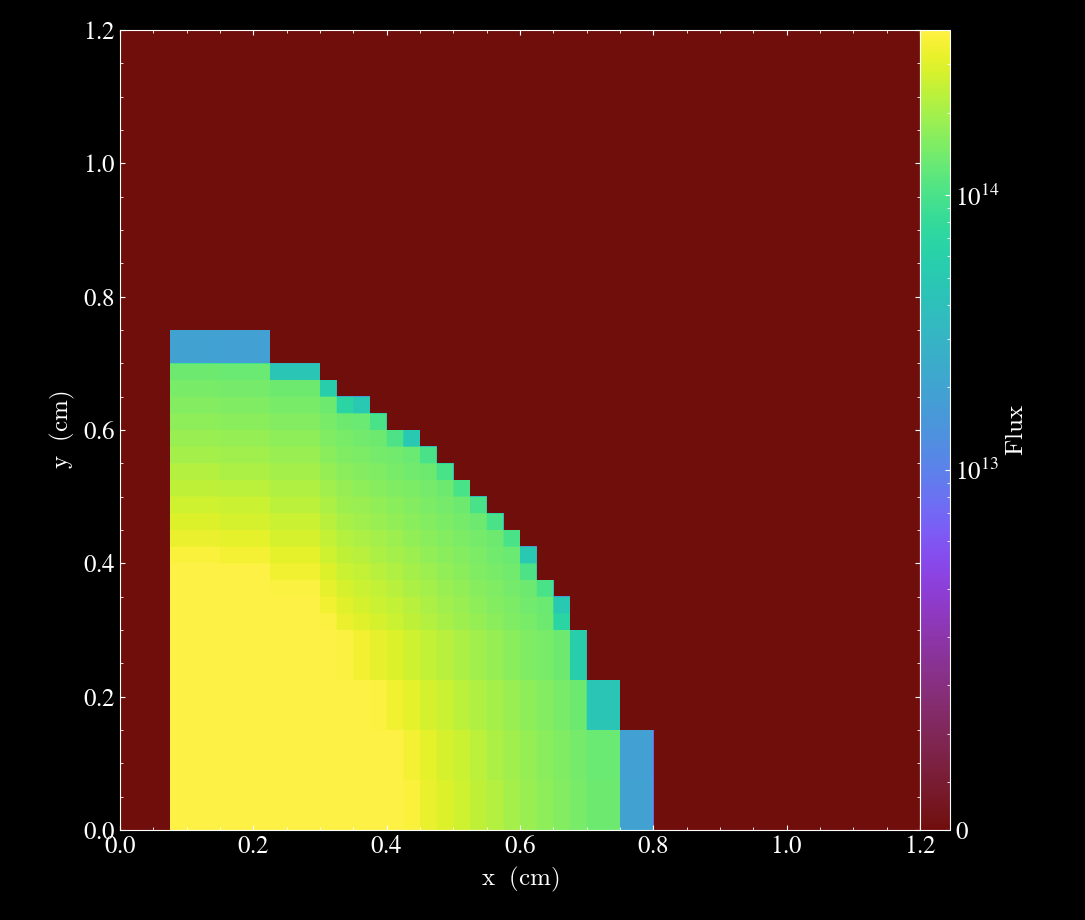

In [11]:
# Create a PyneMoabHex8Dataset using the reactor mesh
pf = PyneMoabHex8Dataset(rx)

# Set the field and axis for the slice plot
field = 'flux'
axis = 'z'

# Create the SlicePlot object
s = SlicePlot(pf, axis, field, origin='native')

# Display the plot
s.display()


### Solve in time

The `render` function steps through time calling the `timestep` function and then creating an image.  The images that are generated are then dumped into a movie.

In [12]:
def render(m, dt, axis="z", field="flux", frames=100):
    pf = PyneMoabHex8Dataset(m)
    s = SlicePlot(pf, axis, field, origin='native')
    fig = s.plots['pyne', field].figure
    fig.canvas = FigureCanvasAgg(fig)
    axim = fig.axes[0].images[0]

    def init():
        axim = s.plots['pyne', 'flux'].image
        return axim

    def animate(i):
        s = SlicePlot(pf, axis, field, origin='native')
        axim.set_data(s._frb['pyne', field])
        timestep(m, dt)
        return axim

    return animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=False)


anim = render(rx, dt=2.5e-40, frames=10)

# Set up formatting for the movie files
Writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
anim.save('animation.mp4', writer=Writer)

HTML(anim.to_html5_video())